In [73]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# df = pd.read_csv(r'D:/Course/FirstSemester/GHPIM/GHPIM_med/nhanes_metSyn_20220316.csv')
df = pd.read_csv('./nhanes_metSyn_20220316.csv')
df = pd.DataFrame(columns = df.columns.tolist(), data = df)
df.columns.tolist()

for i in df.columns:
    if i not in 'ckd':
        df[i] = df[i].fillna(df[i].mean())
df['ckd'] = df['ckd'].fillna(0)

df.head()

['SEQN',
 'ATP_MS',
 'IDF_MS',
 'race',
 'sex',
 'AGE',
 'WT',
 'BMI',
 'height',
 'WAIST',
 'waist_hip_ratio',
 'BMPTRI',
 'BMPSUB',
 'BMPSUP',
 'BMPTHI',
 'HR',
 'SBP',
 'DBP',
 'HB',
 'HCT',
 'PLT',
 'TCHO',
 'TG',
 'LDL',
 'HDL',
 'ApoA',
 'ApoB',
 'fibriongen',
 'CRP',
 'uric_acid',
 'GLU',
 'BUN',
 'T_bilirubin',
 'Creatinine',
 'GOT',
 'GPT',
 'diabetes_told',
 'insulin',
 'oral_hypoglycemic_agent',
 'anti_hypertensive',
 'Smoking',
 'MDRD_eGFR',
 'ckd',
 'followupmonth',
 'allcausedeath']

In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve,auc,mean_squared_error
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

def CrossValidation(model,x,y,cv):
    k_fold=KFold(n_splits=cv,shuffle=False)
    acc_list=[]
    for i,(train_index,val_index) in enumerate(k_fold.split(x),start=1):
        model.fit(x[train_index],y[train_index].ravel())
        y_pred  = model.predict(x[val_index])
        acc_list.append(model.score(x[val_index],y[val_index]))
    return round(sum(acc_list)/cv,2)

def PlotRocCurve(y_labels,y_pre,plt_title,label):
    fpr,tpr,thresholds=roc_curve(y_labels,y_pre)
    auc_data=auc(fpr,tpr)
    plt.plot(fpr, tpr, label=label, lw=2)
    plt.title(plt_title)
    plt.ylabel('sensitivity')
    plt.xlabel('1-specificity')
    plt.legend(loc='lower right')
    return round(auc_data,2)
def Calculate_Sensitivity_Specificity(y_preds,y_labels):
    tn,fp,fn,tp=confusion_matrix(y_labels,y_preds).ravel()
    specificity=round(tn/(tn+fp),2)
    sensitivity=round(tp/(tp+fn),2)
    return sensitivity,specificity

In [45]:
from sklearn.model_selection import train_test_split
import numpy as np

X = df.drop('allcausedeath',axis=1).drop('SEQN',axis=1).drop('ApoB',axis=1).drop('ApoA',axis=1).drop('insulin',axis=1).drop('oral_hypoglycemic_agent', axis=1).drop('followupmonth', axis=1).values
y = df['allcausedeath'].values.reshape(-1, 1).astype('int')



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print('Training data shape:', X_train.shape)
print('Testing data shape:', X_test.shape)


Training data shape: (2516, 38)
Testing data shape: (280, 38)


訓練集 Score:  0.9937244480293786
測試集 Score:  0.26130607076833556


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


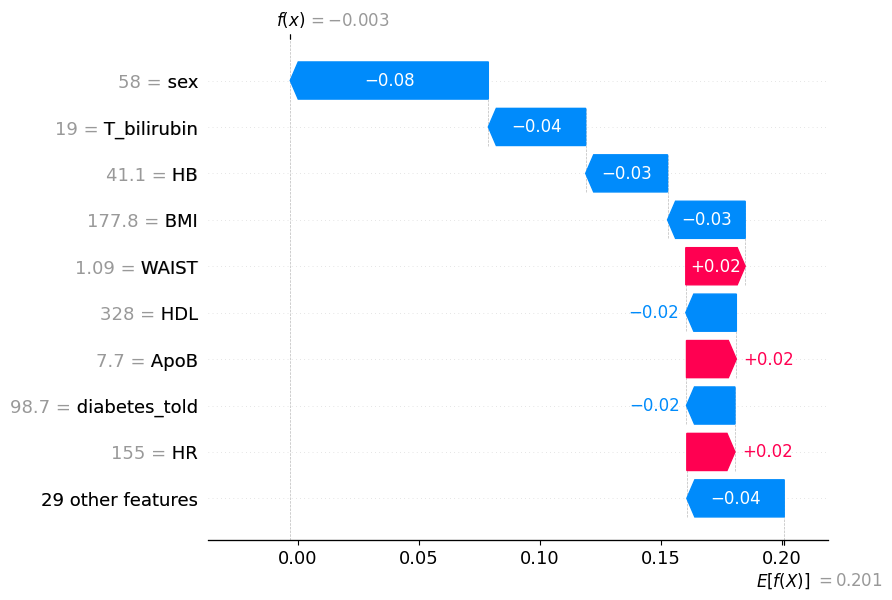

In [88]:
from xgboost import XGBRegressor
import shap



xgboostModel = XGBRegressor()

xgboostModel.fit(X_train, y_train)

predicted = xgboostModel.predict(X_train)

print("訓練集 Score: ", xgboostModel.score(X_train,y_train))
print("測試集 Score: ", xgboostModel.score(X_test,y_test))


explainer = shap.Explainer(xgboostModel,feature_names=df.columns)
shap_values = explainer(X_train)

shap.plots.waterfall(shap_values[0])


In [47]:
# shap.plots.force(explainer.expected_value, shap_values.values,shap_values.data)

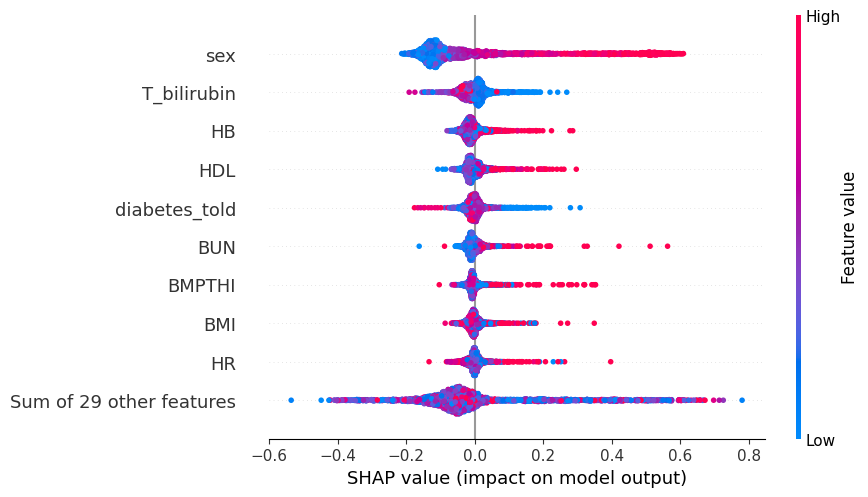

In [89]:
shap.plots.beeswarm(shap_values)

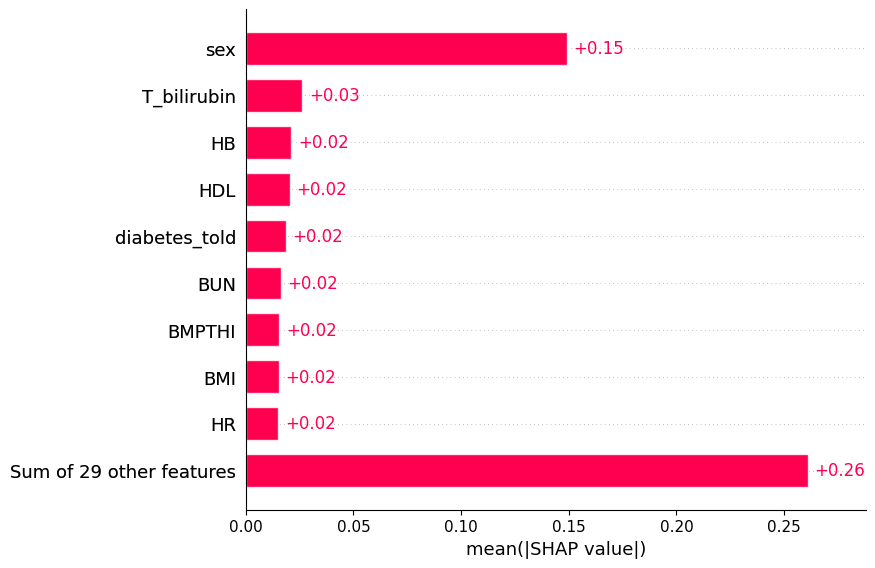

In [90]:
shap.plots.bar(shap_values)

In [50]:
from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import confusion_matrix


logistic = LogisticRegression(solver='lbfgs',max_iter=4000)
logistic.fit(X_train, y_train.ravel())

pred = logistic.predict(X_test)
logistic_sensitivity,logistic_specificity=Calculate_Sensitivity_Specificity(y_preds=pred,y_labels=y_test)

LogisticRegression_Cv=CrossValidation(logistic,X_train,y_train,cv=10)

print("LogisticRegression")
print("訓練集 Score: ", round(logistic.score(X_train,y_train),2))
print("測試集 Score: ", round(logistic.score(X_test,y_test),2))
print('交叉驗證: ',round(LogisticRegression_Cv,2))
print(f"Sensitivity: {logistic_sensitivity}")
print(f"Specificity: {logistic_specificity}")

LogisticRegression
訓練集 Score:  0.86
測試集 Score:  0.83
交叉驗證:  0.85
Sensitivity: 0.46
Specificity: 0.93


In [51]:
from sklearn.tree import  DecisionTreeClassifier
from sklearn.metrics import confusion_matrix


decision = DecisionTreeClassifier()
decision.fit(X_train, y_train.ravel())

pred = decision.predict(X_test)
decision_sensitivity,decision_specificity=Calculate_Sensitivity_Specificity(y_preds=pred,y_labels=y_test)

decision_Cv=CrossValidation(decision,X_train,y_train,cv=10)

print("DecisionTree")
print("訓練集 Score: ", round(decision.score(X_train,y_train),2))
print("測試集 Score: ", round(decision.score(X_test,y_test),2))
print('交叉驗證: ',round(decision_Cv,2))
print(f"Sensitivity: {decision_sensitivity}")
print(f"Specificity: {decision_specificity}")

DecisionTree
訓練集 Score:  0.98
測試集 Score:  0.78
交叉驗證:  0.79
Sensitivity: 0.46
Specificity: 0.84


In [59]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix


svm = SVC(probability=True)
svm.fit(X_train, y_train.ravel())

pred = svm.predict(X_test)
svc_sensitivity,svc_specificity=Calculate_Sensitivity_Specificity(y_preds=pred,y_labels=y_test)

svc_Cv=CrossValidation(svm,X_train,y_train,cv=10)

print("SVM")
print("訓練集 Score: ", round(svm.score(X_train,y_train),2))
print("測試集 Score: ", round(svm.score(X_test,y_test),2))
print('交叉驗證: ',round(svc_Cv,2))
print(f"Sensitivity: {svc_sensitivity}")
print(f"Specificity: {svc_specificity}")

SVM
訓練集 Score:  0.8
測試集 Score:  0.79
交叉驗證:  0.8
Sensitivity: 0.0
Specificity: 1.0


In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


randomforest = RandomForestClassifier(n_estimators=100, random_state=0)
randomforest.fit(X_train, y_train.ravel())

pred = randomforest.predict(X_test)
randomforest_sensitivity,randomforest_specificity=Calculate_Sensitivity_Specificity(y_preds=pred,y_labels=y_test)

randomforest_Cv=CrossValidation(randomforest,X_train,y_train,cv=10)

print("RandomForest")
print("訓練集 Score: ", round(randomforest.score(X_train,y_train),2))
print("測試集 Score: ", round(randomforest.score(X_test,y_test),2))
print('交叉驗證: ',round(randomforest_Cv,2))
print(f"Sensitivity: {randomforest_sensitivity}")
print(f"Specificity: {randomforest_specificity}")

RandomForest
訓練集 Score:  0.98
測試集 Score:  0.83
交叉驗證:  0.86
Sensitivity: 0.39
Specificity: 0.94


In [65]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix


bayes = GaussianNB()
bayes.fit(X_train, y_train.ravel())

pred = bayes.predict(X_test)
bayes_sensitivity,bayes_specificity=Calculate_Sensitivity_Specificity(y_preds=pred,y_labels=y_test)

bayes_Cv=CrossValidation(bayes,X_train,y_train,cv=10)

print("Bayes")
print("訓練集 Score: ", round(bayes.score(X_train,y_train),2))
print("測試集 Score: ", round(bayes.score(X_test,y_test),2))
print('交叉驗證: ',round(bayes_Cv,2))
print(f"Sensitivity: {bayes_sensitivity}")
print(f"Specificity: {bayes_specificity}")

Bayes
訓練集 Score:  0.82
測試集 Score:  0.78
交叉驗證:  0.82
Sensitivity: 0.58
Specificity: 0.84


In [53]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(is_unbalance=True)
lgb_model.fit(X_train,y_train.ravel())

pred=lgb_model.predict(X_test)
lgbm_sensitivity,lgbm_specificity=Calculate_Sensitivity_Specificity(y_preds=pred,y_labels=y_test)

LGBMClassifier_Cv=CrossValidation(lgb_model,X_train,y_train,cv=10)


print("LGBMClassifier")
print("訓練集 Score: ", round(lgb_model.score(X_train,y_train),2))
print("測試集 Score: ", round(lgb_model.score(X_test,y_test),2))
print("交叉驗證: ",LGBMClassifier_Cv)
print(f"Sensitivity: {lgbm_sensitivity}")
print(f"Specificity: {lgbm_specificity}")

LGBMClassifier
訓練集 Score:  0.98
測試集 Score:  0.82
交叉驗證:  0.85
Sensitivity: 0.56
Specificity: 0.9


In [54]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train.ravel())

xgboostModel = XGBClassifier(n_estimators=100, learning_rate= 0.3)
xgboostModel.fit(X_train, y_train.ravel())

pred=xgboostModel.predict(X_test)
xgb_sensitivity,xgb_specificity=Calculate_Sensitivity_Specificity(y_preds=pred,y_labels=y_test)

XGBClassifier_Cv=CrossValidation(xgboostModel,X_train,y_train,cv=10)

print("XGBClassifer")
print('訓練集: ',round(xgboostModel.score(X_train,y_train),2))
print('測試集: ',round(xgboostModel.score(X_test,y_test),2))
print(f"交叉驗證:{XGBClassifier_Cv} ")
print(f"Sensitivity: {xgb_sensitivity}")
print(f"Specificity: {xgb_specificity}")

XGBClassifer
訓練集:  0.98
測試集:  0.85
交叉驗證:0.85 
Sensitivity: 0.47
Specificity: 0.92


In [61]:
from sklearn import ensemble
bag = ensemble.BaggingClassifier(n_estimators = 100)
bag_fit = bag.fit(X_train, y_train)

# 預測
predicted = bag.predict(X_test)
bagging_sensitivity,bagging_specificity=Calculate_Sensitivity_Specificity(y_preds=pred,y_labels=y_test)
# ROC AUc
BaggingClassifier_Cv=CrossValidation(bag,X_train,y_train,cv=10)
# 績效
print("EnsembleLearning(bagging)")
print('訓練集: ',round(bag.score(X_train,y_train),2))
print('測試集: ',round(bag.score(X_test,y_test),2))
print('交叉驗證: ',round(BaggingClassifier_Cv,2))
print(f"Sensitivity: {bagging_sensitivity}")
print(f"Specificity: {bagging_specificity}")

EnsembleLearning(bagging)
訓練集:  0.98
測試集:  0.84
交叉驗證:  0.85
Sensitivity: 0.0
Specificity: 1.0


In [56]:
from sklearn import ensemble


ada_boost = ensemble.AdaBoostClassifier(n_estimators = 100)
boost_fit = ada_boost.fit(X_train, y_train)

# 預測
predicted = ada_boost.predict(X_test)
adaboost_sensitivity,adaboost_specificity=Calculate_Sensitivity_Specificity(y_preds=pred,y_labels=y_test)
# ROC AUC
AdaBoostClassifier_Cv=CrossValidation(ada_boost,X_train,y_train,cv=10)

# 績效
print("AdaBoostClassifier")
print('訓練集: ',round(ada_boost.score(X_train,y_train),2))
print('測試集: ',round(ada_boost.score(X_test,y_test),2))
print("交叉驗證: ",round(AdaBoostClassifier_Cv,2))
print(f"Sensitivity: {adaboost_sensitivity}")
print(f"Specificity: {adaboost_specificity}")

AdaBoostClassifier
訓練集:  0.88
測試集:  0.82
交叉驗證:  0.84
Sensitivity: 0.47
Specificity: 0.92


Logistic_AUC:0.81
LGBM_AUC:0.79
Bagging_AUC:0.82
XGBoost_AUC:0.8
AdaBoost_AUC:0.77
Decisiontree_AUC:0.66
SVM_AUC:0.77
Randomforest_AUC:0.83
bayes_AUC:0.77


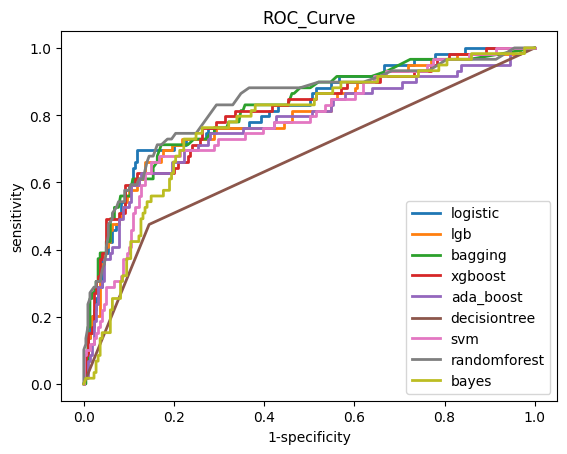

In [67]:
logistic_auc=PlotRocCurve(y_test,logistic.predict_proba(X_test)[:,1],plt_title='ROC_Curve',label='logistic')
lgb_auc=PlotRocCurve(y_test,lgb_model.predict_proba(X_test)[:,1],plt_title='ROC_Curve',label='lgb')
bagging_auc=PlotRocCurve(y_test,bag.predict_proba(X_test)[:,1],plt_title='ROC_Curve',label='bagging')
xgboost_auc=PlotRocCurve(y_test,xgboostModel.predict_proba(X_test)[:,1],plt_title='ROC_Curve',label='xgboost')
adaboost_auc=PlotRocCurve(y_test,ada_boost.predict_proba(X_test)[:,1],plt_title='ROC_Curve',label='ada_boost')
decision_auc=PlotRocCurve(y_test,decision.predict_proba(X_test)[:,1],plt_title='ROC_Curve',label='decisiontree')
svm_auc=PlotRocCurve(y_test,svm.predict_proba(X_test)[:,1],plt_title='ROC_Curve',label='svm')
randomforest_auc=PlotRocCurve(y_test,randomforest.predict_proba(X_test)[:,1],plt_title='ROC_Curve',label='randomforest')
bayes_auc=PlotRocCurve(y_test,bayes.predict_proba(X_test)[:,1],plt_title='ROC_Curve',label='bayes')
print(f"Logistic_AUC:{logistic_auc}")
print(f"LGBM_AUC:{lgb_auc}")
print(f"Bagging_AUC:{bagging_auc}")
print(f"XGBoost_AUC:{xgboost_auc}")
print(f"AdaBoost_AUC:{adaboost_auc}")
print(f"Decisiontree_AUC:{decision_auc}")
print(f"SVM_AUC:{svm_auc}")
print(f"Randomforest_AUC:{randomforest_auc}")
print(f"bayes_AUC:{bayes_auc}")